In [80]:
import numpy as np
from tqdm import tqdm 
from sklearn.datasets import make_circles
from sklearn.metrics import log_loss, accuracy_score
import matplotlib.pyplot as plt

![init](multi_layer_png/init.png "init")

In [81]:
def initialisation(n0, n1, n2):
    W1 = np.random.rand(n1, n0)
    b1 = np.random.randn(n1, 1)
    W2 = np.random.rand(n2, n1)
    b2 = np.random.randn(n2, 1)

    parametres = {
        'W1' : W1,
        'b1' : b1,
        'W2' : W2,
        'b2' : b2,
    }
    return parametres

In [82]:
def forward_propagation(X, parametres): # Ancienne fonction model()
    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    Z1 = W1 @ X + b1
    A1 = 1 / (1 + np.exp(-Z1))
    Z2 = W2 @ A1 + b2 # Pour une seconde couche nous ne prenons plus les X mais les a, ils les remplacent
    A2 = 1 / (1 + np.exp(-Z2))

    activations = {
        'A1' : A1,
        'A2' : A2,
    }

    return activations

![back_propagation](multi_layer_png/back_propagation.png "back_propagation")

In [83]:
def back_propagation(X, y, parametres, activations):
    A1 = activations['A1']
    A2 = activations['A2']
    W2 = parametres['W2']

    m = y.shape[1]

    dZ2 = A2 - y
    dW2 = 1 / m * dZ2 @ A1.T
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) # On met le parametre keepdims true pour garder les dimensions, car avec le broadcasting que nous executerons, cela peut casser les dims de la matrice.   

    dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)
    dW1 = 1 / m * dZ1 @ X.T
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        'dW1' : dW1,
        'db1' : db1,
        'dW2' : dW2,
        'db2' : db2
    }

    return gradients

![update](multi_layer_png/update.png "update")

In [84]:
def update(gradients, parametres, learning_rate): 
    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parametres = {
        'W1' : W1,
        'b1' : b1,
        'W2' : W2,
        'b2' : b2,
    }
    
    return parametres

In [85]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    A2 = activations['A2']
    return A2 >= 0.5 # C’est une classification, si sigmoïde > 50%, groupe 1.

![artificial_nerons](multi_layer_png/artificial_nerons.png "artificial_nerons")

![init_neural_network](multi_layer_png/init_neural_network.png "init_neural_network")

In [94]:
def neural_network(X, y, n1, learning_rate = 0.1, n_iter = 100):

    # Initialisation des paramétres
    n0 = X.shape[0] # C’est le nombre d’entrée X
    # n1 est une entrée de fonction que nous définiront
    n2 = y.shape[0] # C’est la sorti
    parametres = initialisation(n0, n1, n2)

    # Train
    train_loss = []
    train_acc = []
    history = []

    # Descente de gradients
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parametres)
        A2 = activations['A2']

        # Plot courbe d'apprentissage
        train_loss.append(log_loss(y.flatten(), A2.flatten()))
        y_pred = predict(X, parametres)
        train_acc.append(accuracy_score(y.flatten(), y_pred.flatten())) # Applatir les tableaux 2D pour sklearn => (n2, 1) -> (n2, )
        
        history.append([parametres.copy(), train_loss, train_acc, i])

        # mise a jour
        gradients = back_propagation(X, y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.legend
    plt.show()

    x_min, x_max = X[0, :].min() - 0.1, X[0, :].max() + 0.1
    y_min, y_max = X[1, :].min() - 0.1, X[1, :].max() + 0.1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T  # Passer en format (2, nb_points)

    # Prédire la classe de chaque point de la grille
    predictions = predict(grid_points, parametres)
    predictions = predictions.reshape(xx.shape)  # Remettre en forme pour l'affichage

    # Affichage
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, predictions, cmap="summer", alpha=0.5)  # Colorier les zones de décision
    plt.scatter(X[0, :], X[1, :], c=y, cmap="summer", edgecolors="k")  # Superposer les points originaux
    plt.title("Frontière de décision")
    plt.show()

    return parametres 
    

dimensions de X: (2, 100)
dimensions de y: (1, 100)


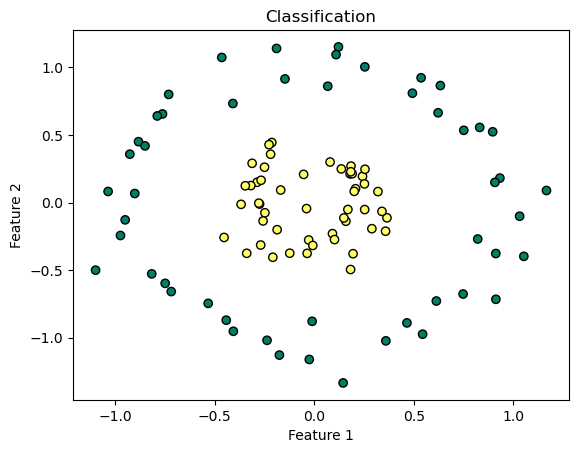

In [95]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3 ,random_state=0)
# Transposition de X et y
X = X.T
y = y.reshape((1 , y.shape[0]))

print("dimensions de X:", X.shape)
print("dimensions de y:", y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap="summer", edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Classification")
plt.show()


100%|██████████| 10000/10000 [00:09<00:00, 1062.60it/s]


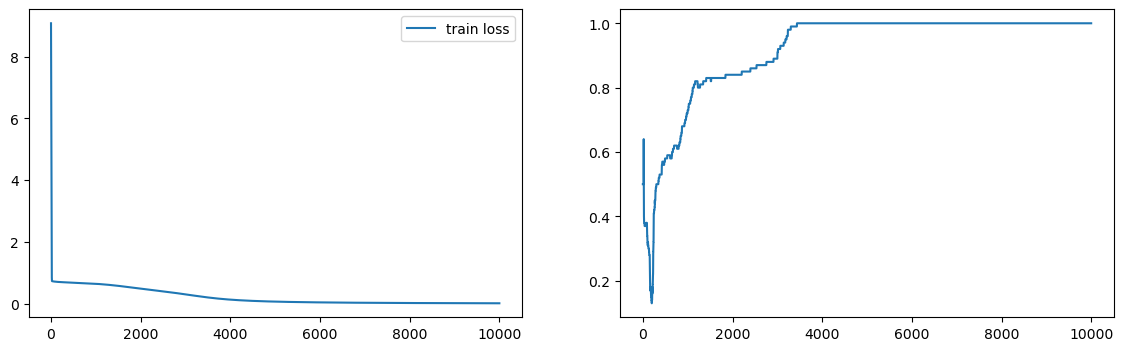

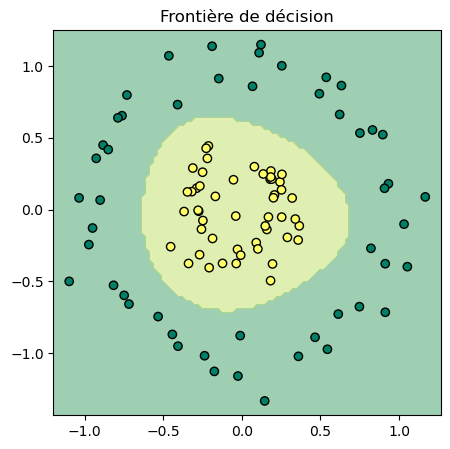

In [102]:
parametres = neural_network(X, y, n1=64, n_iter=10000, learning_rate=0.1) # Toujours utiliser des puissances de 2 pour n1, question optimisation mémoire